# **MachineRay2** - Image Generation
By Robert. A Gonsalves
![MachineRay Output](https://raw.githubusercontent.com/robgon-art/MachineRay2/main/sample%202%20wide.jpg)

This is a project that uses AI to create abstract art.

I gathered images of abstract paintings from WikiArt.org, processed them, and fed them into StyleGAN2 ADA at the size of 1024x1024.
I trained the GAN for four days on a GPU using Google Colab.
I then processed the output images by adjusting the aspect ratio and running them through another ANN for a super-resolution resize.
The resultant images are 4096 pixels wide or tall, depending on the aspect ratio.

This Google Colaboratory allows you to generate unique abstract art automatically.

The source code and generated images are released under the [CC BY-NC-SA license](https://creativecommons.org/licenses/by-nc-sa/4.0/).</br>
![CC BY-NC-SA](https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png)

# **Initalize the System**
Hit the Run Cell (play) button to intialize the system.

In [ ]:
# https://towardsdatascience.com/machineray-using-ai-to-create-abstract-art-39829438076a
# %tensorflow_version 1.x
!git clone https://github.com/NVlabs/stylegan2-ada
!wget -O "network-snapshot-000188.pkl" "https://www.dropbox.com/s/ya3swqh2t165nkn/network-snapshot-000188.pkl?dl=0"
!wget -O painting_info.txt "https://www.dropbox.com/s/h2bktown2oq2avq/painting_info.txt?dl=0"
inited_ISR = False

Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71
Unpacking objects: 100% (71/71), done.
--2021-03-26 19:55:01--  https://www.dropbox.com/s/ya3swqh2t165nkn/network-snapshot-000188.pkl?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ya3swqh2t165nkn/network-snapshot-000188.pkl [following]
--2021-03-26 19:55:01--  https://www.dropbox.com/s/raw/ya3swqh2t165nkn/network-snapshot-000188.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7c26b0012d8c406e0bc65c5fee.dl.dropboxusercontent.com/cd/0/inline/BLaTkwvayfXBC2-IEdhTjIceBugRJ3etGhHp1An9aDMKIQNQmbSjmyTEDT6QPkTyQu95tLoK3vnoM6kkatKTGDQEsvD9PTff5a2fHUwHnFQoVm2yIKHsvnCr7c2g1KE1XJviN5PLgu

# **Generate a Sample of Paintings and Show Thumbnails**
Hit the Run Cell button to generate 21 thumbnail images using MachineRay.

Loading networks from "network-snapshot-000188.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Compiling... Loading... Done.
Generating image for seed 48992 (0/21) ...
Generating image for seed 48993 (1/21) ...
Generating image for seed 48994 (2/21) ...
Generating image for seed 48995 (3/21) ...
Generating image for seed 48996 (4/21) ...
Generating image for seed 48997 (5/21) ...
Generating image for seed 48998 (6/21) ...
Generating image for seed 48999 (7/21) ...
Generating image for seed 49000 (8/21) ...
Generating image for seed 49001 (9/21) ...
Generating image for seed 49002 (10/21) ...
Generating image for seed 49003 (11/21) ...
Generating image for seed 49004 (12/21) ...
Generating image for seed 49005 (13/21) ...
Generating image for seed 49006 (14/21) ...
Generating image for seed 49007 (15/21) ...
Generating image for seed 49008 (16/21) ...
Generating image for seed 49009 (17/21) ...
Generat

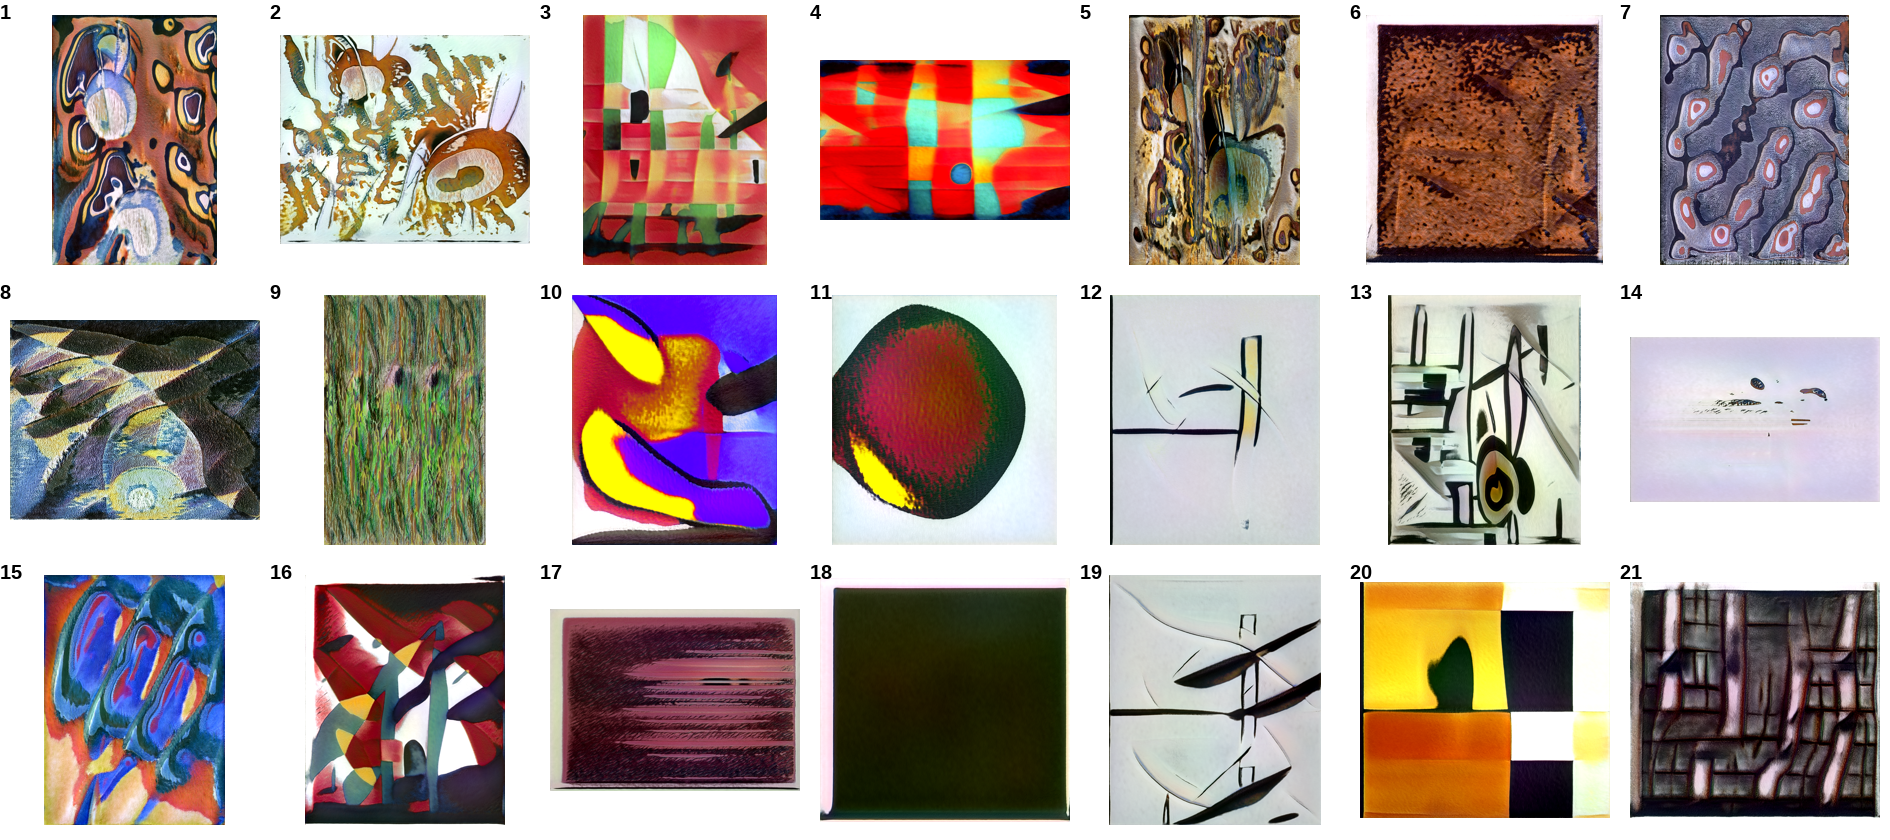

In [ ]:
%tensorflow_version 1.x
import os
from PIL import Image, ImageOps, ImageFont, ImageDraw
import numpy as np
import random

# Clear out the results folder if it exists
if os.path.exists("results"):
  !rm -r results

# Pick a number, any number
seed = random.randint(0,100000)
seed_arg = "--seeds="

for i in range(20):
  seed_arg += str(seed+i) + ","
seed_arg += str(seed+20)

# Generate the images
!python stylegan2-ada/generate.py $seed_arg --trunc=1.4  \
  --outdir results --network=network-snapshot-000188.pkl

# Initialize the x and y arrays
x = np.linspace(0, 849, 850)
y = np.empty(shape=(850))

# Read the file containing the paintings and aspect ratios
info_file = open('painting_info.txt', 'r')
lines = info_file.readlines()

# Use this font
fnt = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', 20)

# Loop through the lines, capturing the aspect ratio in the y array
count = 0
for line in lines:
  parts = line.split(' ')
  if len(parts) == 2 and len(parts[1]) > 0:
    y[count] = parts[1]
  count += 1

# Sort the values
y = np.sort(y)

# Use piecewise linear interpolation
def get_aspect_ratio():
  input_x = np.random.rand(1)*850
  y_interp = np.interp(input_x, x, y)
  return y_interp[0]

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

# Get all the image file names
image_files = []
for root, dirs, files in os.walk("results"):
    files.sort()
    for file in files:
        if file.endswith(".png"):
             image_files.append(os.path.join(root, file))

# Generate a grid of thumbnails
aspect_ratios = []
size = 250
count = 0
for j in range(0, 3):
  for i in range(0, 7):
    tile = Image.open(image_files[count])
    aspect = get_aspect_ratio()
    aspect_ratios.append(aspect)

    if aspect<1:
      newsize = (int(size * aspect), size)
    else:
      newsize = (size, int(size / aspect))

    tile = tile.resize(newsize)

    delta_w = size - newsize[0] + 20
    delta_h = size - newsize[1] + 30
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    tile = ImageOps.expand(tile, padding, fill = (255, 255, 255))

    draw = ImageDraw.Draw(tile)
    draw.text((0, 0), str(count+1), font=fnt, fill=(0,0,0))

    if i%7 == 0:
      row = tile
    else:
      row = get_concat_h(row, tile)

    count += 1

  if j%4 == 0:
    group = row
  else:
    group = get_concat_v(group, row)

# Show the thumbnails
group

# **Choose a Painting**
Choose a thumbnail with the slider and hit the Run Cell button to see the full sized image at 1024 pixels wide or tall.

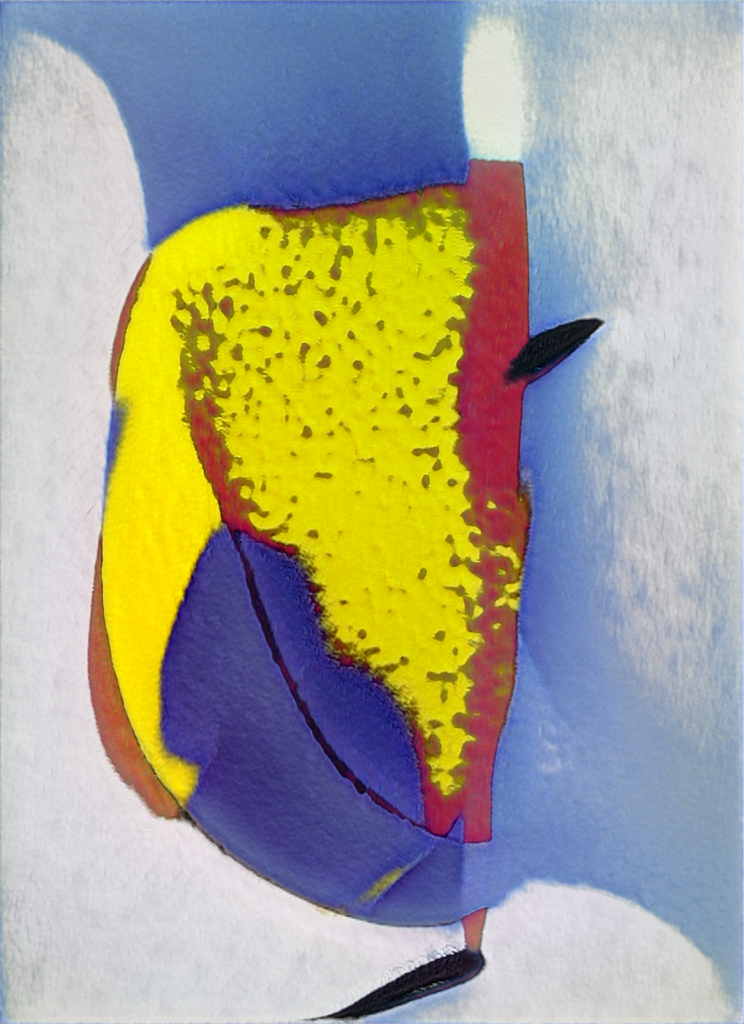

In [ ]:
chosen_thumbnail = 5 #@param {type:"slider", min:1, max:21, step:1}
image = Image.open(image_files[chosen_thumbnail-1])
size = 1024
aspect = aspect_ratios[chosen_thumbnail-1]

if aspect<1:
  newsize = (int(size * aspect), size)
else:
  newsize = (size, int(size / aspect))

resized = image.resize(newsize)
resized

# **Generate a Super-Resolution Resized Painting (Optional)**
Hit the Run Cell button to generate a Super-Resolution resized painting.

Note that this takes a couple of minutes to run.

In [ ]:
if inited_ISR == False:
  %tensorflow_version 2.x
  !pip install ISR
  from ISR.models import RDN, RRDN
  from google.colab import files
  model = RRDN(weights='gans')
  inited_ISR = True

npimg = np.array(resized)
row,col,ch= npimg.shape
mean = 0
var = 0.1
sigma = var**0.5
gauss = np.random.normal(mean,sigma,(row,col,ch))*24
gauss = gauss.reshape(row,col,ch)
noisy = np.clip(npimg + gauss, 0, 255).astype('uint8')
noisy_image = Image.fromarray(noisy)
print("Creating the Super-Resolution resized image.")
print("This will take a couple of minutes.")
big_img_np = model.predict(np.array(noisy_image))
big_img = Image.fromarray(big_img_np)
file_name = "big" + str(chosen_thumbnail) + ".jpg"
big_img.resize((big_img.width//2, big_img.height//2))

# **Download the High-Res Painting (Optional)**
Hit the Run Cell button to dowload the full-sized painting.

Make sure to enable downloads in your browser.

In [ ]:
big_img.save(file_name)
files.download(file_name)